# Segunda práctica de Aprendizaje Automático

Implementación del grupo 17, formado por:
- Sergio Barragán Blanco (100472343)
- Eduardo Alarcón Navarro (100472175)


Este trabajo trata sobre usar métodos de clustering para agrupar estrellas dados algunos parámetros, como son la temperatura, color, radio, luminosidad.....
Para ello, usaremos el StandardScaler para los datos, y dado que dos variables son categóricas, aplicaremos también Encoders para su transformación, decidiremos cuál de los tres métodos de clustering (KMeans, DBSCAN y Hierchical Clustering) es mejor para nuestros datos, y aplicaremos PCA a los mismos para poder verlos representados.

# Lectura del fichero CSV
Lo primero de todo es la lectura del fichero, debido a que posteriormente será necesario hacer varias copias de los datos, se introducirá la lectura en una función 

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
import time
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from itertools import product 



# Carga de datos
def load_data():
    data = pd.read_csv('Stars2.csv')
    return data
data = load_data()


# Implementación local del Kmeans
A continuación, haremos nuestra propia implementación con el objetivo de, posteriormente, comparar nuestra implementación con la oficial de scikit-learn

In [20]:

class Kmeans():
    def __init__(self, n_clusters=8, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = 343175
        self.cluster_centers_ = None
        self.labels_ = None

    def fit(self, X, y=None, sample_weight=None):
        # Inicialización de los centroides de manera aleatoria
        rng = np.random.default_rng(self.random_state)
        self.cluster_centers_ = rng.choice(X, size=self.n_clusters, replace=False)

        for _ in range(self.max_iter):
            self._assign_labels(X)

            new_centers = self._compute_centers(X, self.labels_)

            if np.allclose(self.cluster_centers_, new_centers, atol=self.tol):
                break
            
            self.cluster_centers_ = new_centers

    def _assign_labels(self, X):
        labels = np.empty(X.shape[0], dtype=int)
        for i, x in enumerate(X):
            # Calcular la distancia euclidiana a cada centroide
            distances = np.linalg.norm(self.cluster_centers_ - x, axis=1)
            # Asignar el punto al clúster con la distancia más corta
            labels[i] = np.argmin(distances)
        self.labels_ = labels

    def _compute_centers(self, X, labels):
        new_centers = np.empty_like(self.cluster_centers_)
        for i in range(self.n_clusters):
            # Calcular el nuevo centroide como el promedio de los puntos asignados al clúster i
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centers[i] = np.mean(cluster_points, axis=0)
            else:
                # Si no hay puntos asignados al clúster, mantener el centroide actual
                new_centers[i] = self.cluster_centers_[i]
        return new_centers


# A continuación, haremos el encoding de los datos, podemos hacer tanto OneHot como Ordinal
Dado que nuestro objetivo principal es la comparación de ambos KMeans, vamos a usar Ordinal Encoder para las dos columnas de datos de clasificación, ya que ambas se rigen por un orden.

In [21]:
# Dado que las instancias de la columa "Color", son variadas lo primero, es normalizarlas
mapping = {
    "Red": ["Red"],
    "Orange-Red": ["Orange-Red"],
    "Orange": ["Orange"],
    "Yellow-Orange": ["Pale yellow orange"],
    "Yellow": ["yellowish", "Yellowish"],
    "White-Yellow": ["Yellowish White", "yellow-white", "White-yellow"],
    "White": ["White", "Whitish", "white"],
    "Blue-white": ["Blue-White", "Blue-white", "Blue White", "Blue white"],
    "Blue": ["Blue"]
}
normalized_colors = list(mapping.keys())

# ChatGPT redució la función a esto
data['Color'] = data['Color'].apply(lambda x: next((k for k, v in mapping.items() if x in v), x))

# Codificación ordinal de los colores
color_encoder = OrdinalEncoder(categories=[normalized_colors])
color_encoded = color_encoder.fit_transform(data[['Color']])

# Como la clase espectral si es consistente, no se le aplicará normalización y haremos directamente el encoding
spectral_encoder = OrdinalEncoder(categories=[['O', 'B', 'A', 'F', 'G', 'K', 'M']])
spectral_class_encoded = spectral_encoder.fit_transform(data[['Spectral_Class']])

data['Color'] = color_encoded
data['Spectral_Class'] = spectral_class_encoded


# Preparación de los datos y comparaciones
Aplicaremos un Standard Scaler a los datos, y un PCA para reducir la dimensionalidad tratando de mantener la mayor cantidad de información posible y comparar ambos KMeans usando gráficos de burbujas.

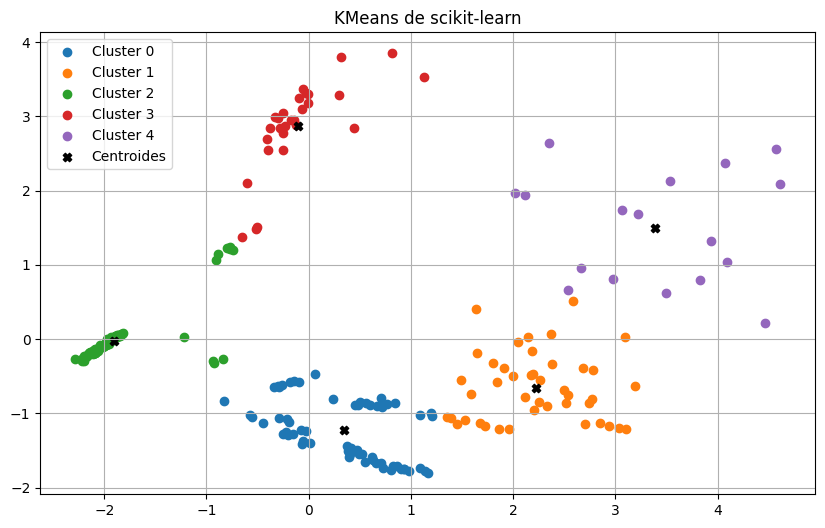

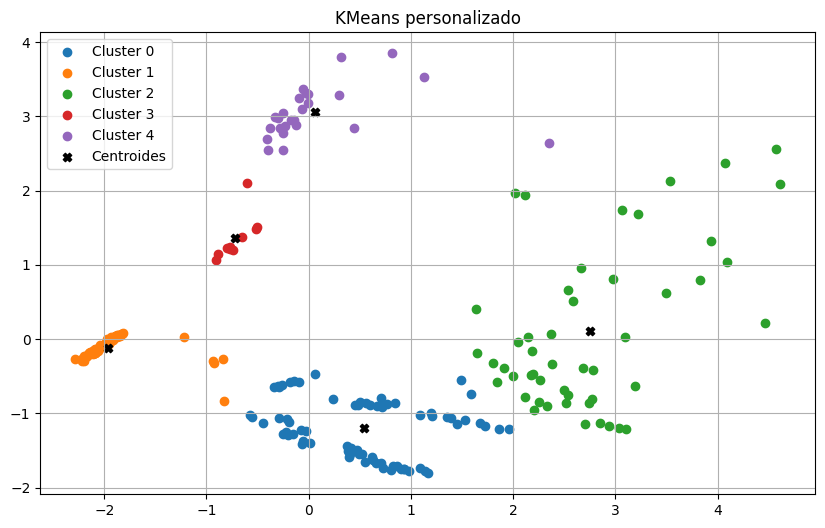

In [22]:
# Escalado de características
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
"""Aquí empieza la implemetación oficial de KMeans de scikit-learn"""
# Clustering con KMeans
start_time = time.time()
kmeans = KMeans(n_clusters=5, random_state=472175)
kmeans.fit(data_pca)

# Predicciones de cluster
cluster_labels = kmeans.predict(data_pca)
end_time = time.time()

sklearn_time = end_time - start_time
sk_silhouette = silhouette_score(data_pca, cluster_labels)

# Y lo mostramos en una gráfica.
plt.figure(figsize=(10, 6))
for label in np.unique(cluster_labels):
    plt.scatter(data_pca[cluster_labels == label, 0], data_pca[cluster_labels == label, 1], label=f'Cluster {label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', color='black', label='Centroides')

plt.title('KMeans de scikit-learn')
plt.legend()
plt.grid(True)
plt.show()

"""Por último implementamos nuestro propio KMeans, el cual se inicializa de manera similar, pero se llama con la n en minúscula"""
start_time = time.time()
kmeans = Kmeans(n_clusters=5)
kmeans.fit(data_pca)
end_time = time.time()

cluster_labels_local = kmeans.labels_

local_time = end_time - start_time
local_silhouette = silhouette_score(data_pca, cluster_labels_local)

# Mostrando los resultados
plt.figure(figsize=(10, 6))
for label in np.unique(cluster_labels_local):
    plt.scatter(data_pca[cluster_labels_local == label, 0], data_pca[cluster_labels_local == label, 1], label=f'Cluster {label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', color='black', label='Centroides')

plt.title('KMeans personalizado')
plt.legend()
plt.grid(True)
plt.show()


### Comparaciones
A simple vista, podemos observar cómo, teniendo ambos 5 centroides para el algortimo, la implementación oficial se decanta por separar la zona inferior derecha en 3 clusters, mientras que nuestra implementación en dos, y por el contrario, compensa separando la zona superior con tres clusters en vez de dos. Sin aplicar ninguna métrica de puntuación, parece que ambas implementaciones son correctas, pero para tener una prueba más solída para comparar ambos métodos, vamos a comparar su tiempo de ejecución y su puntuación usando la silhouette score de métrica


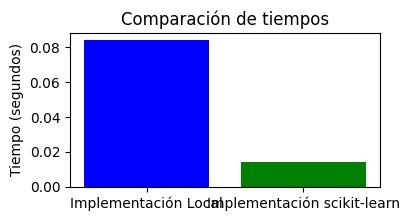

SCORES
Local: 0.6377694148999287	SkLearn: 0.6451947033112416


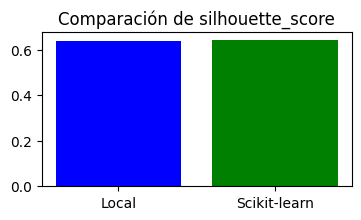

In [23]:
t_names = ['Implementación Local', 'Implementación scikit-learn']

# Valores de los tiempos
times = [local_time, sklearn_time]

# Crear gráfico de barras para los tiempos
plt.figure(figsize=(4,2))
plt.bar(t_names, times, color=['blue', 'green'])

# Agregar título y etiquetas
plt.title('Comparación de tiempos')
plt.ylabel('Tiempo (segundos)')

# Mostrar la gráfica
plt.show()

# Y ahora haremos la comparación con la silhouette score
s_names = ['Local', 'Scikit-learn']

s_scores = [local_silhouette, sk_silhouette]
print(f"SCORES\nLocal: {local_silhouette}\tSkLearn: {sk_silhouette}")
# Crear gráfico de barras
plt.figure(figsize=(4,2))
plt.bar(s_names, s_scores, color=['blue', 'green'])
# Agregar título y etiquetas
plt.title('Comparación de silhouette_score')
plt.show()

### Conclusiones
Como se puede observar a pesar de que con 5 centroides ambos algoritmos los distribuyen de manera diferente (con 6 es el mismo), el tiempo que toma la implementación local es varias veces mayor que la tomada por sk-learn, además de que dan un score similar, siendo ligeramente mejor el de scikit-learn, por lo que podemos concluir que la implementación local no le sobrepasa en ningún ámbito.


# Comparación de Encoders y de métodos de clustering
Una vez hemos comaprados ambos Kmeans usando usando el mismo método con los datos (ordinal encoder), vamos a comprobar si nuestra decisión fué la correcta, probando ahora con OneHot encoding y con algortimos de clustering como hierchical o DBSCAN.

#### OneHot Encoding VS Ordinal Encoding
Para probar cual es mejor para nuestro conjunto de entrenamiento, usaremos copias de los datos originales y le iremos aplicando todas las posibles combinaciones de ambos encoders, almacenando los resultados para ser posteriormente evaluados por los métodos de clustering.

In [24]:

# Para evitar problemas innecesarios, crearemos una copia nueva para los datos y trabajaremos sobre ella
data = pd.read_csv('Stars2.csv')
# Dado que los problemas de mapeo vuelven a surgir, será necesario volver a normalizar el color
mapping = {
    "Red": ["Red"],
    "Orange-Red": ["Orange-Red"],
    "Orange": ["Orange"],
    "Yellow-Orange": ["Pale yellow orange"],
    "Yellow": ["yellowish", "Yellowish"],
    "White-Yellow": ["Yellowish White", "yellow-white", "White-yellow"],
    "White": ["White", "Whitish", "white"],
    "Blue-white": ["Blue-White", "Blue-white", "Blue White", "Blue white"],
    "Blue": ["Blue"]
}
normalized_colors = list(mapping.keys())

data['Color'] = data['Color'].apply(lambda x: next((k for k, v in mapping.items() if x in v), x))
spectrum = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Lista para almacenar los resultados
master_data = []

# Iterar sobre todas las combinaciones de codificación para color y clase espectral
for color_encoding, spectral_encoding in product(['O', 'H'], repeat=2):
    df = data.copy()
    
    # Codificación ordinal de color
    if color_encoding == 'O':
        color_encoder = OrdinalEncoder(categories=[normalized_colors])
        df['Color_Encoded'] = color_encoder.fit_transform(df[['Color']])
    else:
        color_encoder = OneHotEncoder(categories=[normalized_colors])
        color_encoded = color_encoder.fit_transform(df[['Color']])
        color_encoded_df = pd.DataFrame(color_encoded.toarray(), columns=[f'Color_{i}' for i in range(1, 10)])
        df = pd.concat([df, color_encoded_df], axis=1)
    
    # Codificación ordinal de clase espectral
    if spectral_encoding == 'O':
        spectral_encoder = OrdinalEncoder(categories=[spectrum])
        df['Spectral_Class_Encoded'] = spectral_encoder.fit_transform(df[['Spectral_Class']])
    else:
        spectral_encoder = OneHotEncoder(categories=[spectrum])
        spectral_encoded = spectral_encoder.fit_transform(df[['Spectral_Class']])
        spectral_encoded_df = pd.DataFrame(spectral_encoded.toarray(), columns=[f'Spectral_Class_{i}' for i in range(1, 8)])
        df = pd.concat([df, spectral_encoded_df], axis=1)
    
    # Eliminar las columnas originales de color y clase espectral
    df.drop(['Color', 'Spectral_Class'], axis=1, inplace=True)
    
    # Agregar la tupla a master_data
    master_data.append((color_encoding, spectral_encoding, df))



### Analisis de los Encoders
Para hacer un análisis preliminar de ambos encoders, vamos ha calcular la silhouette score con el KMeans  de scikit-learn, y al mejor, mostraremos en un gráfico en un gráfico con su evolución de la score con diferentes clusters. Y aplicaremos también el método del codo.

No obstante, para determinar cual va a ser la mejor combinación, usaremos ambos encoders con todos los métodos de clustering.

In [25]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(np.unique(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return np.nan

param_grid_kmeans = {
    'n_clusters': [5, 6, 7, 8] ,
    'init': ['k-means++', 'random'],
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-3, 1e-2]
}

scores = {}

# Aplicar StandardScaler y PCA a todas las combinaciones de datos
for color_encoding, spectral_encoding, df in master_data:
    print(f"Data Combination: Color Encoding - {color_encoding}, Spectral Encoding - {spectral_encoding}")
    
    # Aplicar StandardScaler
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    # Aplicar PCA con 2 componentes
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_scaled)

    
    ## Hacer un Kmeans con un siluette score usando los datos de arriba, los encodados, los 4 OO, OH, HO y HH
    # Y de ahí, sacar el mejor valor, y es lo que usarmoes para los clusters. 
    grid_search = GridSearchCV(KMeans(random_state=472175), {}, scoring=silhouette_scorer, n_jobs=-1)
    grid_search.fit(df_pca)
    print(f"Best silhouette score: {grid_search.best_score_}")
    scores[(color_encoding, spectral_encoding)] = (grid_search.best_score_, df_pca)



Data Combination: Color Encoding - O, Spectral Encoding - O
Best silhouette score: 0.6303346953852316
Data Combination: Color Encoding - O, Spectral Encoding - H
Best silhouette score: 0.6552524700587405
Data Combination: Color Encoding - H, Spectral Encoding - O
Best silhouette score: 0.6356953359561519
Data Combination: Color Encoding - H, Spectral Encoding - H
Best silhouette score: 0.693395022639969


### Conclusiones de los Encoders
Como podemos observar, la que parece ser la mejor combinación de encoders para el KMeans, es H-H, es decir, usando OneHot en ambas variables categóricas, lo cual es bastante sorprendente, ya que dichas variables están relaccionadas con las numéricas y poseen un orden.

No obstante, dado que han sido los datos con la mejor puntuación (y con bastante diferencia), son los que serán usados para aplciar el método del codo y la representación del silhouette para el KMeans

### Método del codo y shilhoutte para KMeans


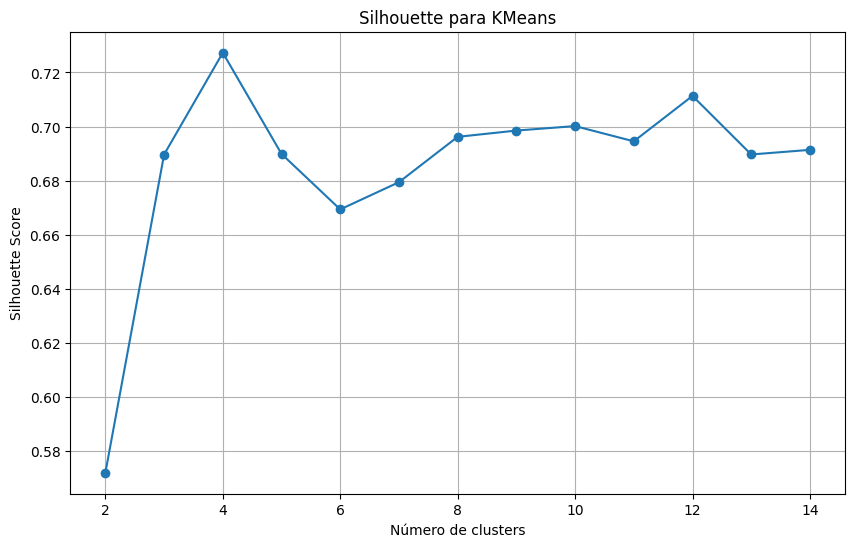

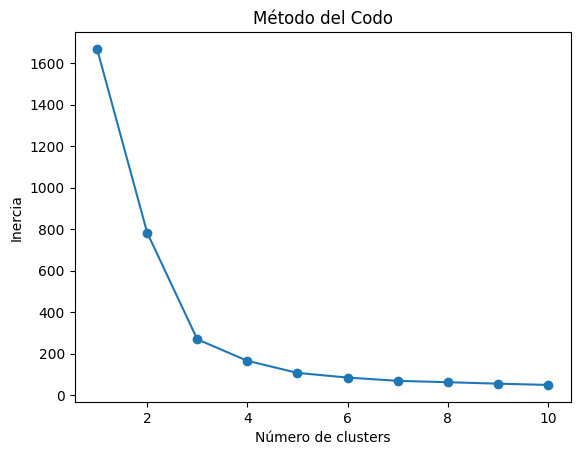

In [26]:

mejor_combinacion = max(scores.items(), key=lambda x: x[1][0])

df_pca_mejor_combinacion = mejor_combinacion[1][1]


# Con estos datos, podemos ver que el mejor es :
"""
Data Combination: Color Encoding - H, Spectral Encoding - H
Algorithm: KMeans
Best parameters: {'init': 'random', 'max_iter': 300, 'n_clusters': 5, 'tol': 0.01}
Best silhouette score: 0.7333663060804909
"""
# Por lo que utilizaremos un Kmeans con 5 clusters, con los datos de Color Encoding - O, Spectral Encoding - H


# Ahora vamos a hacer el método del codo con los dos algorithmos, KMenas y Hierarchical Clustering
# Vamos a ver el scoring con diferentes valores de clusters
scores = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=472175)
    kmeans.fit(df_pca_mejor_combinacion)
    scores.append(silhouette_score(df_pca_mejor_combinacion, kmeans.labels_))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 15), scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette para KMeans')
plt.grid(True)
plt.show()


#################################
####### Método del codo #########
#################################

# Calcular la inercia para diferentes valores de n_clusters
inercia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='random', max_iter=300, tol=0.01, random_state=0)
    kmeans.fit(df_pca_mejor_combinacion)
    inercia.append(kmeans.inertia_)

# Graficar la curva de la inercia
plt.plot(range(1, 11), inercia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.show()

    

Donde podemos obsevar, que la mejor score obtenida con el método silhouette, es con 4 clusters. Y que, gracias al método del codo, podemos saber que el número de clusters óptimo para KMeans es aproximadamente 5.


#### KMeans VS Hierchical VS DBSCAN
Ahora que ya tenemos almacenadas todas las posibles combinaciones para converitr los datos catergóricos, vamos a usar los métodos de clustering para encontrar la mejor combinación para el problema.

Data Combination: Color Encoding - O, Spectral Encoding - O


 ##### Clustering Algorithm: KMeans #####
Color: O && Spectral: O
La mejor puntuación = 0.6809621004851629
 Los mejores parámetos = {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 5, 'tol': 0.0001}
###############################################
######## Puntuaciones, pero sin PCA ###########
###############################################
Color: O && Spectral: O
La mejor puntuación = 0.6158689170109651
 Los mejores parámetos = {'init': 'random', 'max_iter': 100, 'n_clusters': 6, 'tol': 0.0001}


 ##### Clustering Algorithm: Hierarchical Clustering #####
Color: O && Spectral: O
La mejor puntuación = 0.6872832819665886
 Los mejores parámetos = {'compute_distances': True, 'compute_full_tree': True, 'distance_threshold': None, 'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 4}
###############################################
######## Puntuaciones, pero sin PCA ###########
############################################

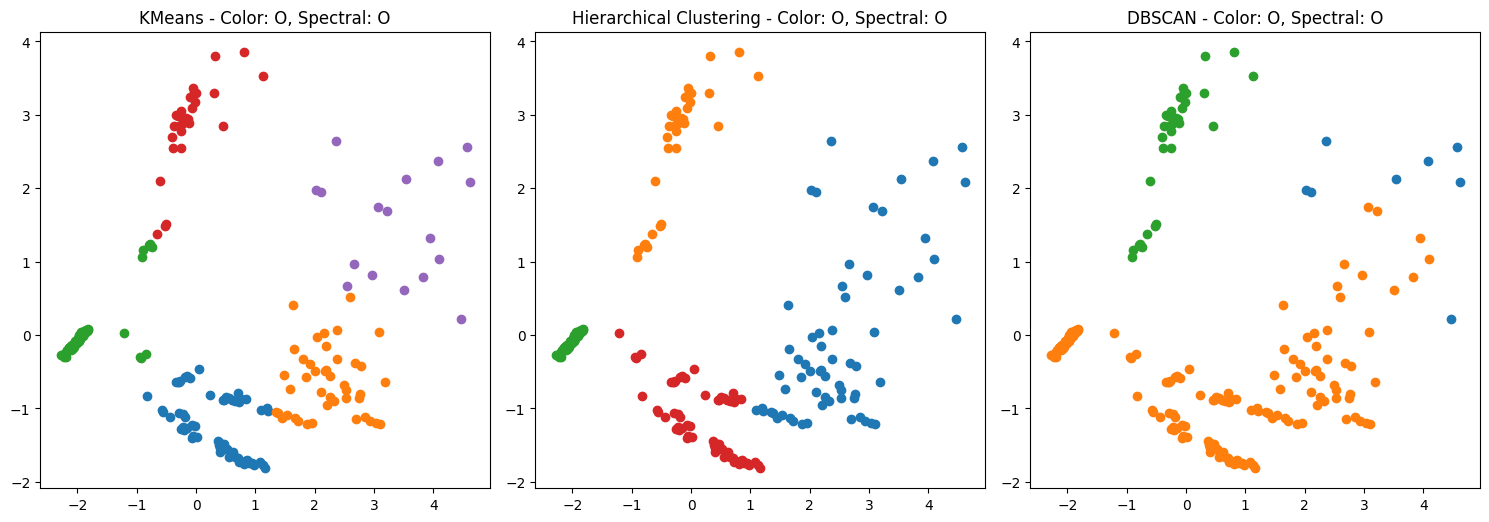

Data Combination: Color Encoding - O, Spectral Encoding - H


 ##### Clustering Algorithm: KMeans #####
Color: O && Spectral: H
La mejor puntuación = 0.7224494341977725
 Los mejores parámetos = {'init': 'random', 'max_iter': 100, 'n_clusters': 5, 'tol': 0.0001}
###############################################
######## Puntuaciones, pero sin PCA ###########
###############################################
Color: O && Spectral: H
La mejor puntuación = 0.7110197441703592
 Los mejores parámetos = {'init': 'random', 'max_iter': 100, 'n_clusters': 6, 'tol': 0.0001}


 ##### Clustering Algorithm: Hierarchical Clustering #####
Color: O && Spectral: H
La mejor puntuación = 0.741771755031625
 Los mejores parámetos = {'compute_distances': True, 'compute_full_tree': True, 'distance_threshold': None, 'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 4}
###############################################
######## Puntuaciones, pero sin PCA ###########
###############################################


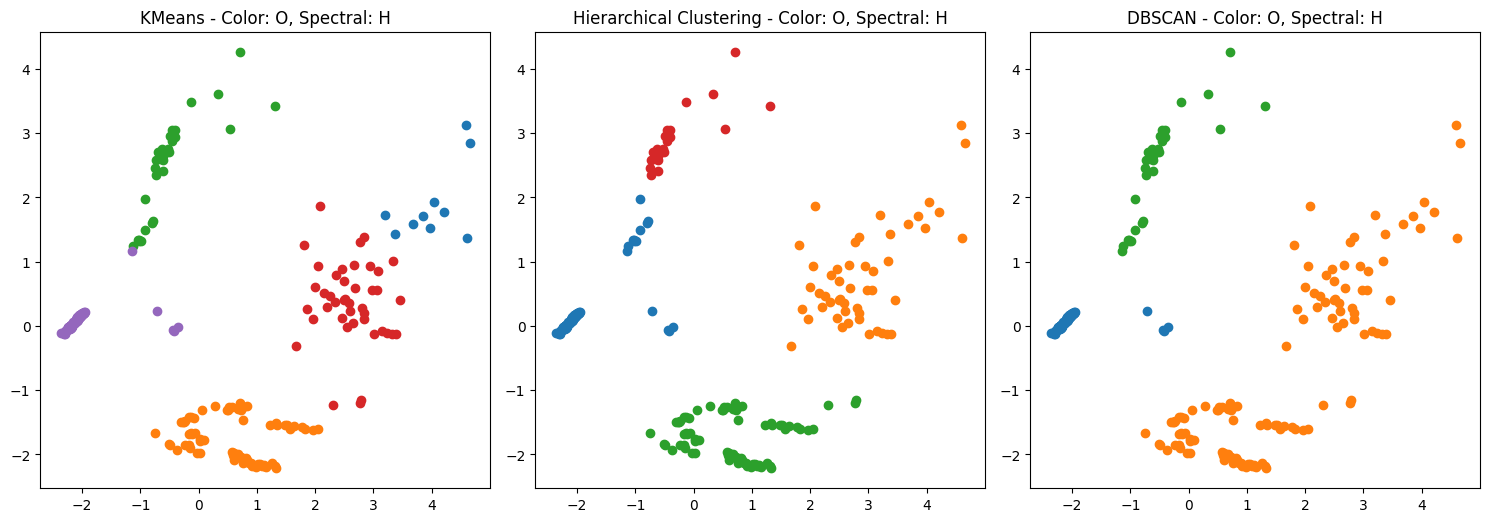

Data Combination: Color Encoding - H, Spectral Encoding - O


 ##### Clustering Algorithm: KMeans #####
Color: H && Spectral: O
La mejor puntuación = 0.7010717284230494
 Los mejores parámetos = {'init': 'random', 'max_iter': 100, 'n_clusters': 5, 'tol': 0.0001}
###############################################
######## Puntuaciones, pero sin PCA ###########
###############################################
Color: H && Spectral: O
La mejor puntuación = 0.6900948954193338
 Los mejores parámetos = {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 7, 'tol': 0.0001}


 ##### Clustering Algorithm: Hierarchical Clustering #####
Color: H && Spectral: O
La mejor puntuación = 0.7163417927779477
 Los mejores parámetos = {'compute_distances': True, 'compute_full_tree': True, 'distance_threshold': None, 'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 4}
###############################################
######## Puntuaciones, pero sin PCA ###########
############################################

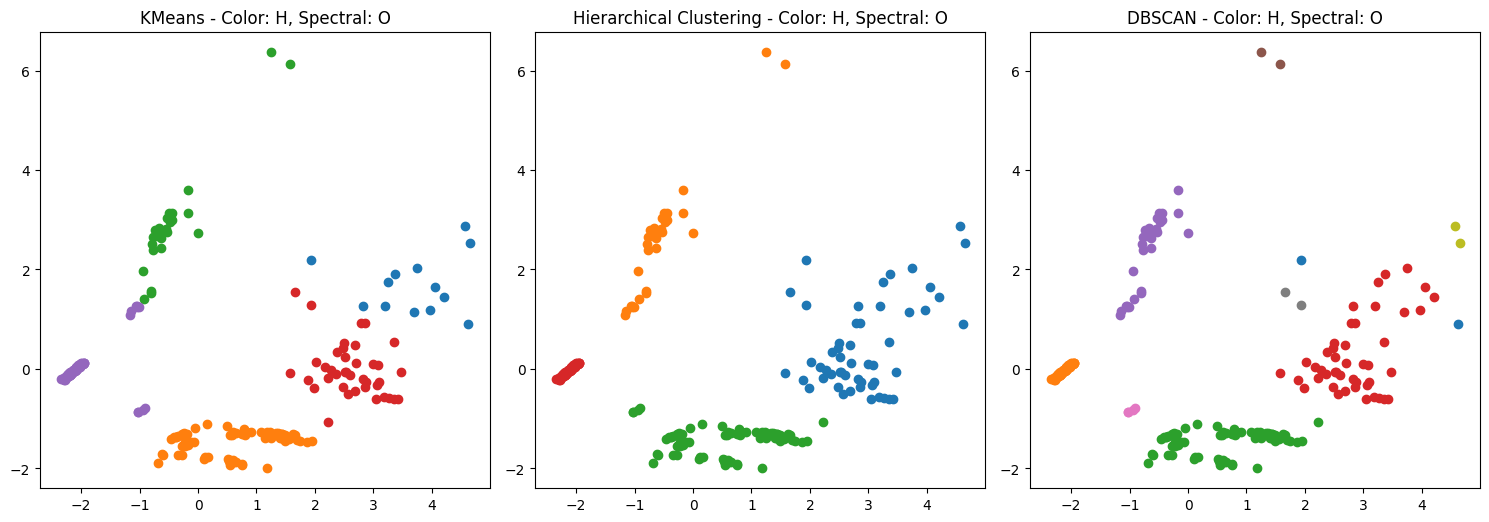

Data Combination: Color Encoding - H, Spectral Encoding - H


 ##### Clustering Algorithm: KMeans #####
Color: H && Spectral: H
La mejor puntuación = 0.7265065381963884
 Los mejores parámetos = {'init': 'random', 'max_iter': 100, 'n_clusters': 5, 'tol': 0.01}
###############################################
######## Puntuaciones, pero sin PCA ###########
###############################################
Color: H && Spectral: H
La mejor puntuación = 0.6860754834142273
 Los mejores parámetos = {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 8, 'tol': 0.0001}


 ##### Clustering Algorithm: Hierarchical Clustering #####
Color: H && Spectral: H
La mejor puntuación = 0.7500325419375903
 Los mejores parámetos = {'compute_distances': True, 'compute_full_tree': True, 'distance_threshold': None, 'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 4}
###############################################
######## Puntuaciones, pero sin PCA ###########
##############################################

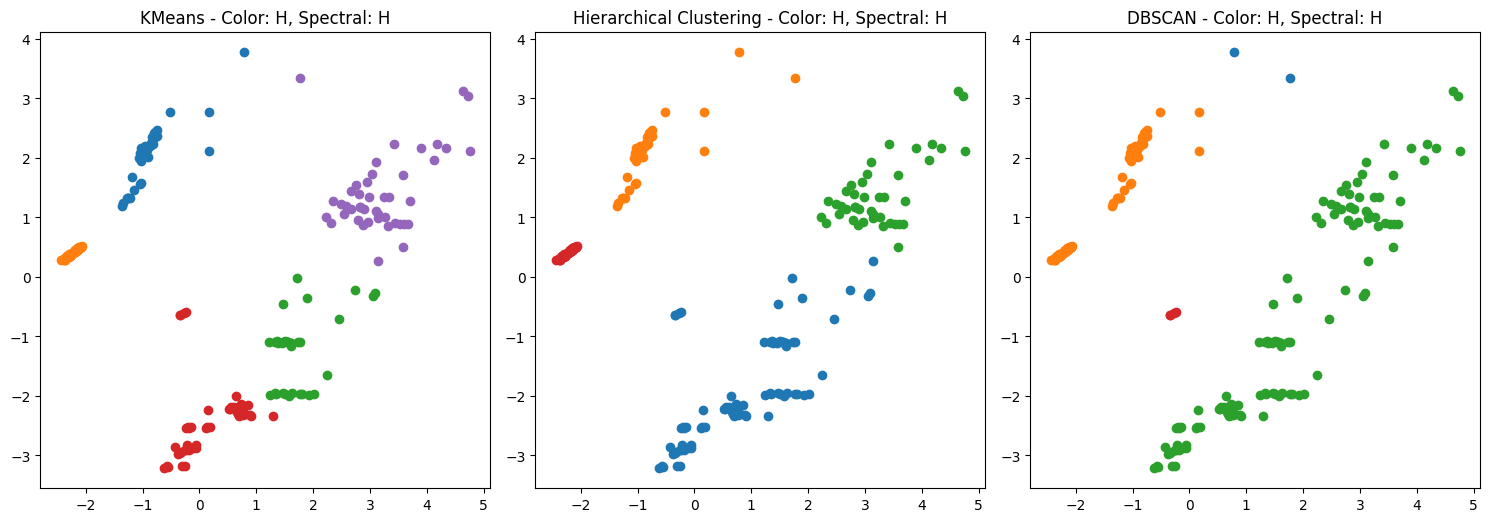

In [27]:
import warnings
warnings.filterwarnings('ignore')

param_grid_hierarchical = {
    'compute_distances': [True, False],
    'compute_full_tree': [True, False],
    'distance_threshold': [None, 1.0, 2.0],  
    'linkage': ['ward', 'complete', 'average', 'single'],
    'metric': ['euclidean', 'manhattan', 'cosine'],  
    'n_clusters': [4, 5, 6, 7, 8] 
}


param_grid_dbscan = {
    'eps': list(np.arange(0.1, 1.1, 0.1)),
    'min_samples': list(range(2, 11)),
    'metric': ['euclidean', 'manhattan', 'cosine']
}


# Definir una lista de algoritmos de clustering
clustering_algorithms = {
    "KMeans": (KMeans(random_state=472175), param_grid_kmeans),
    "Hierarchical Clustering": (AgglomerativeClustering(), param_grid_hierarchical),
    "DBSCAN": (DBSCAN(), param_grid_dbscan)
}

all_scores = {}

# Aplicar StandardScaler y PCA a todas las combinaciones de datos
for color_encoding, spectral_encoding, df in master_data:
    subplot_index = 1

    print(f"Data Combination: Color Encoding - {color_encoding}, Spectral Encoding - {spectral_encoding}")
    
    # Aplicar StandardScaler
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    # Aplicar PCA con 2 componentes
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_scaled)
    
    plt.figure(figsize=(15, 15))

    
    for algorithm_name, algorithm in clustering_algorithms.items():
        print(f"\n\n ##### Clustering Algorithm: {algorithm_name} #####")
        
        grid_search = GridSearchCV(algorithm[0], algorithm[1], scoring=silhouette_scorer, n_jobs=-1)
        # Realizar clustering con el algoritmo actual
        grid_search.fit(df_pca)
        
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_

        print(f"Color: {color_encoding} && Spectral: {spectral_encoding}")
        print(f"La mejor puntuación = {best_score}\n Los mejores parámetos = {best_params}")

        # Mostrar los resultados de los clusters
        best_estimator = grid_search.best_estimator_
        cluster_labels = best_estimator.labels_
        unique_labels = np.unique(cluster_labels)
    
        plt.subplot(3, 3, subplot_index)

        plt.title(f'{algorithm_name} - Color: {color_encoding}, Spectral: {spectral_encoding}')
        
        for label in unique_labels:
            plt.scatter(df_pca[cluster_labels == label, 0], df_pca[cluster_labels == label, 1], label=f'Cluster {label}')
        
        subplot_index += 1

        print("###############################################")
        print("######## Puntuaciones, pero sin PCA ###########")
        print("###############################################")
        grid_search_sin_pca = GridSearchCV(algorithm[0], algorithm[1], scoring=silhouette_scorer, n_jobs=-1)
        grid_search_sin_pca.fit(df_scaled)
        print(f"Color: {color_encoding} && Spectral: {spectral_encoding}")
        print(f"La mejor puntuación = {grid_search_sin_pca.best_score_}\n Los mejores parámetos = {grid_search_sin_pca.best_params_}")
        
        all_scores[(algorithm_name, color_encoding, spectral_encoding)] = (best_score, grid_search_sin_pca.best_score_)

        

    plt.tight_layout()
    plt.show()
    






### Análisis de los métodos de clustering

Para comenzar, usando la combinación de Encoders O-O, se puede observar que las putnuaciones rondadn el 0.68, siendo el mejor KMeans, con una puntuación de 0.688.

Por otra parte, con la combinación O-H, se puede observar que las scores suben considerablemente hasta una media de 0.73, donde el mejor por una ligera ventaja es el Hierarchal Clustering, con una puntuación de 0.734.

Invirtiendo los encoders, con la combinación H-O, se puede observar que las scores bajan ligeramente hasta una media de 0.70, donde destaca es el KMeans con una puntuación de 0.725.

Por último, con la combinación H-H, se puede observar que las scores suben considerablemente hasta una media de 0.736, donde se observa la mejor puntuación de todos los métodos, con un 0.7452670651144014 usando DBSCAN.

## 5. Mejor modelo

Se va a proceder a realizar una pipeline con el mejor modelo obtenido en el apartado anterior. Y se va a ampliar el análisis de busqueda de hiperparámetros para mejorar el modelo.
Pero primero, ordenaremos todas las scores para averiguar cuál es dicho modelo.


In [28]:
# Ordenamos los valores anteriores por PCA (ya que los valores de PCA son siempre mejores que sin PCA)
pca_scores_sorted = sorted(all_scores.items(), key=lambda x: x[1][0], reverse=True)

for elem in pca_scores_sorted:
    print(f"Score para {elem[0]}:")
    print(f"\t\tPCA: {elem[1][0]}\t\t NO PCA: {elem[1][1]}")

Score para ('Hierarchical Clustering', 'H', 'H'):
		PCA: 0.7500325419375903		 NO PCA: 0.704195081959844
Score para ('DBSCAN', 'O', 'H'):
		PCA: 0.7488473559495448		 NO PCA: 0.7194066441562992
Score para ('DBSCAN', 'H', 'H'):
		PCA: 0.745267065114402		 NO PCA: 0.7063053591384436
Score para ('Hierarchical Clustering', 'O', 'H'):
		PCA: 0.741771755031625		 NO PCA: 0.725661268462116
Score para ('KMeans', 'H', 'H'):
		PCA: 0.7265065381963884		 NO PCA: 0.6860754834142273
Score para ('KMeans', 'O', 'H'):
		PCA: 0.7224494341977725		 NO PCA: 0.7110197441703592
Score para ('Hierarchical Clustering', 'H', 'O'):
		PCA: 0.7163417927779477		 NO PCA: 0.7082257294927141
Score para ('KMeans', 'H', 'O'):
		PCA: 0.7010717284230494		 NO PCA: 0.6900948954193338
Score para ('DBSCAN', 'H', 'O'):
		PCA: 0.6996994560713719		 NO PCA: 0.6856613725037541
Score para ('DBSCAN', 'O', 'O'):
		PCA: 0.6882375760990305		 NO PCA: 0.6178575468725125
Score para ('Hierarchical Clustering', 'O', 'O'):
		PCA: 0.68728328196658

### Conclusiones

Se Puede observar que el mejor modelo es el Hierarchical Clustering con OneHot Encoding, con una puntuación de 0.75, siendo el mejor modelo de todos los probados.

Durante la creación de la pipeline, la aplicación del OneHot en ambas variables categóricas se tuvo que hacer separada de la pipe (debido a la transformación del conjunto de datos), no obstante, aún así, no hemos conseguido que los resultados obtenidos de la pipe coincidan con los mostrados anteriormente, por lo que descartaremos la creación del mejor modelo con una pipe y lo haremos paso por paso. 

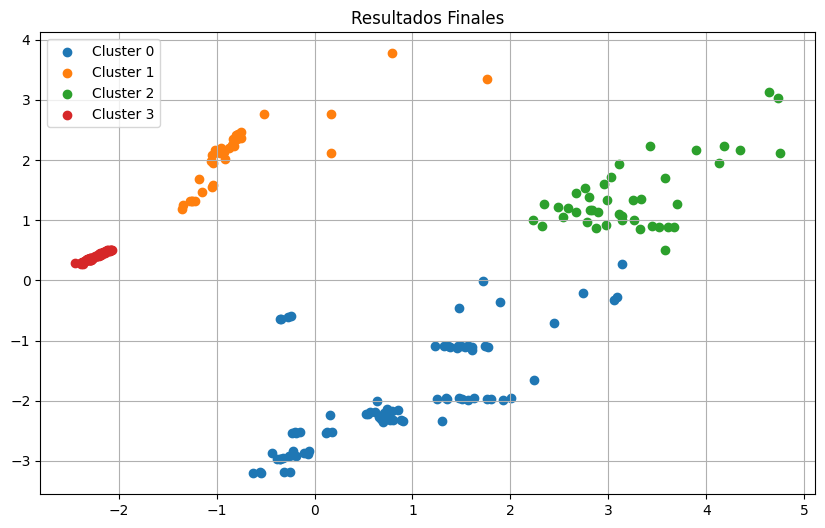

In [29]:
# Dado que las instancias de la columa "Color", son variadas lo primero, es normalizarlas
data = load_data()

mapping = {
    "Red": ["Red"],
    "Orange-Red": ["Orange-Red"],
    "Orange": ["Orange"],
    "Yellow-Orange": ["Pale yellow orange"],
    "Yellow": ["yellowish", "Yellowish"],
    "White-Yellow": ["Yellowish White", "yellow-white", "White-yellow"],
    "White": ["White", "Whitish", "white"],
    "Blue-white": ["Blue-White", "Blue-white", "Blue White", "Blue white"],
    "Blue": ["Blue"]
}
normalized_colors = list(mapping.keys())

data['Color'] = data['Color'].apply(lambda x: next((k for k, v in mapping.items() if x in v), x))
spectrum = ['O', 'B', 'A', 'F', 'G', 'K', 'M']


one_hot_encoder = OneHotEncoder(categories=[normalized_colors])
color_encoded = one_hot_encoder.fit_transform(data[['Color']])
color_encoded_df = pd.DataFrame(color_encoded.toarray(), columns=[f'Color_{i}' for i in range(1, 10)])
data = pd.concat([data, color_encoded_df], axis=1)


spectral_encoder = OneHotEncoder(categories=[spectrum])
spectral_encoded = spectral_encoder.fit_transform(data[['Spectral_Class']])
spectral_encoded_df = pd.DataFrame(spectral_encoded.toarray(), columns=[f'Spectral_Class_{i}' for i in range(1, 8)])
data = pd.concat([data, spectral_encoded_df], axis=1)

data.drop(['Color', 'Spectral_Class'], axis=1, inplace=True)

# Aplicar StandardScaler en una pipeline
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Aplicar PCA con 2 componentes
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Definir los parámetros para DBSCAN
params = {'compute_distances': True, 'compute_full_tree': True, 'distance_threshold': None, 'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 4}

# Crear y ajustar el modelo DBSCAN
hierarch = AgglomerativeClustering(**params)

hierarch.fit(data_pca)
cluster_labels = hierarch.labels_

# Mostrar los resultados
unique_labels = np.unique(cluster_labels)

plt.figure(figsize=(10, 6))
plt.title('Resultados Finales')
for label in unique_labels:
    plt.scatter(data_pca[cluster_labels == label, 0], data_pca[cluster_labels == label, 1], label=f'Cluster {label}')

plt.legend()
plt.grid(True)
plt.show()




# Analasis de los grupos
Para comprobar si los resultados de nuestro modelo final se asemejan a los mostrados en la tabla de la práctica, vamos a realizar la media de las variables numéricas de cada cluster.

In [31]:
# Obtener los datos originales
original_data = load_data()  # Suponiendo que esta función carga los datos originales

# Agregar las etiquetas de clúster al DataFrame original
original_data['Cluster_Label'] = cluster_labels

means = {"Temperature": [], "L": [], "R": [], "A_M": [], "Cluster_Label": []}

# Iterar sobre los clústeres únicos
for label in unique_labels:
    print(f"Medias del cluster {label}:")
    # Find the average in each cluster
    cluster_data = original_data[original_data['Cluster_Label'] == label]
    for column in cluster_data.columns:
        if column not in ['Color', 'Spectral_Class']:
            print(f"\t{column}: {cluster_data[column].mean()}")
            means[column].append((label, cluster_data[column].mean()))

Medias del cluster 0:
	Temperature: 14252.059523809523
	L: 40216.68509934524
	R: 106.62802535714287
	A_M: 5.168369047619048
	Cluster_Label: 0.0
Medias del cluster 1:
	Temperature: 3689.5588235294117
	L: 234088.23529411765
	R: 1020.5882352941177
	A_M: -8.999117647058823
	Cluster_Label: 1.0
Medias del cluster 2:
	Temperature: 22511.95238095238
	L: 342571.54761904763
	R: 315.3044523809524
	A_M: -6.67945238095238
	Cluster_Label: 2.0
Medias del cluster 3:
	Temperature: 3140.8875
	L: 0.0030495125
	R: 0.22908
	A_M: 15.051737500000002
	Cluster_Label: 3.0


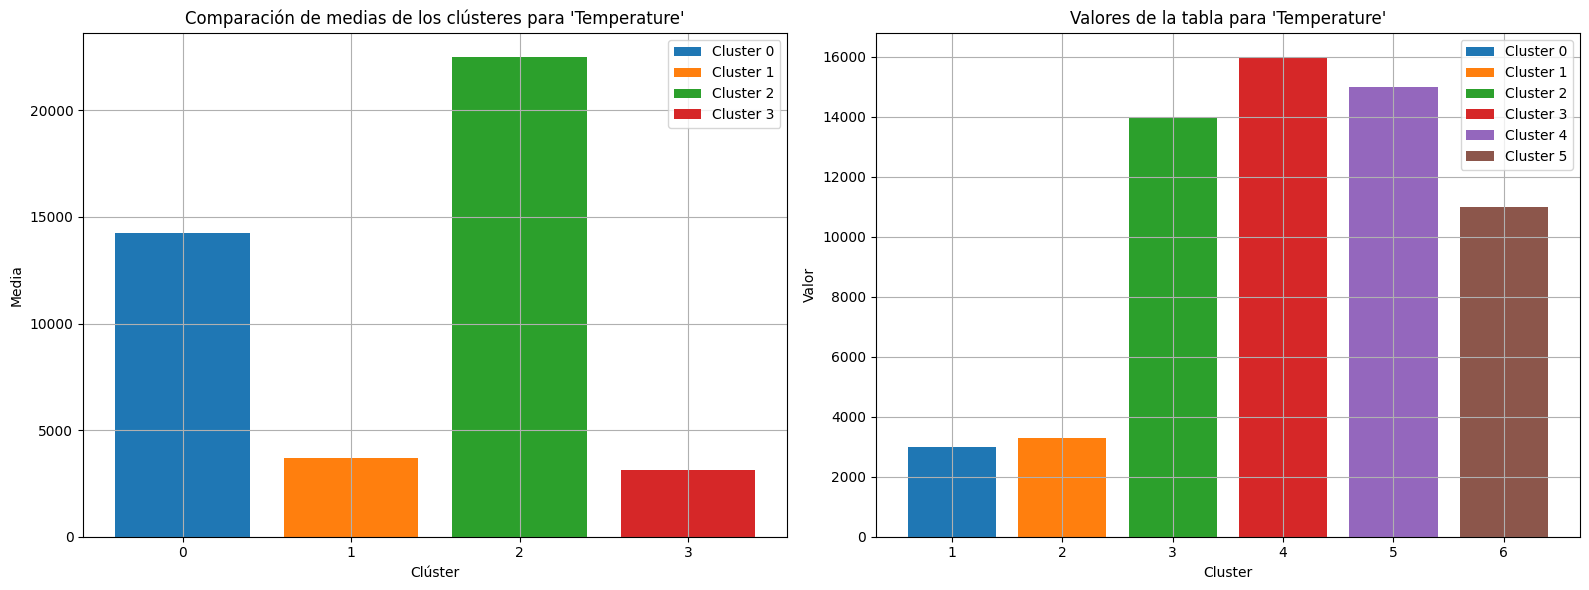

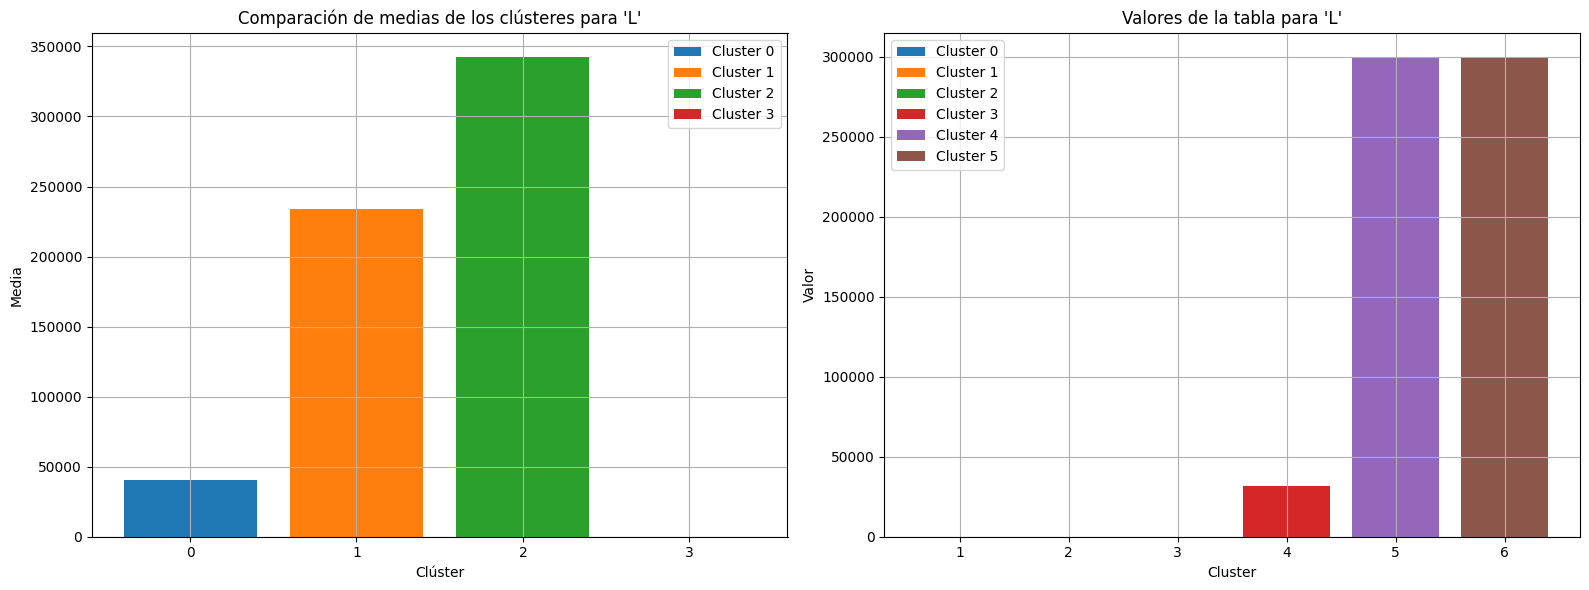

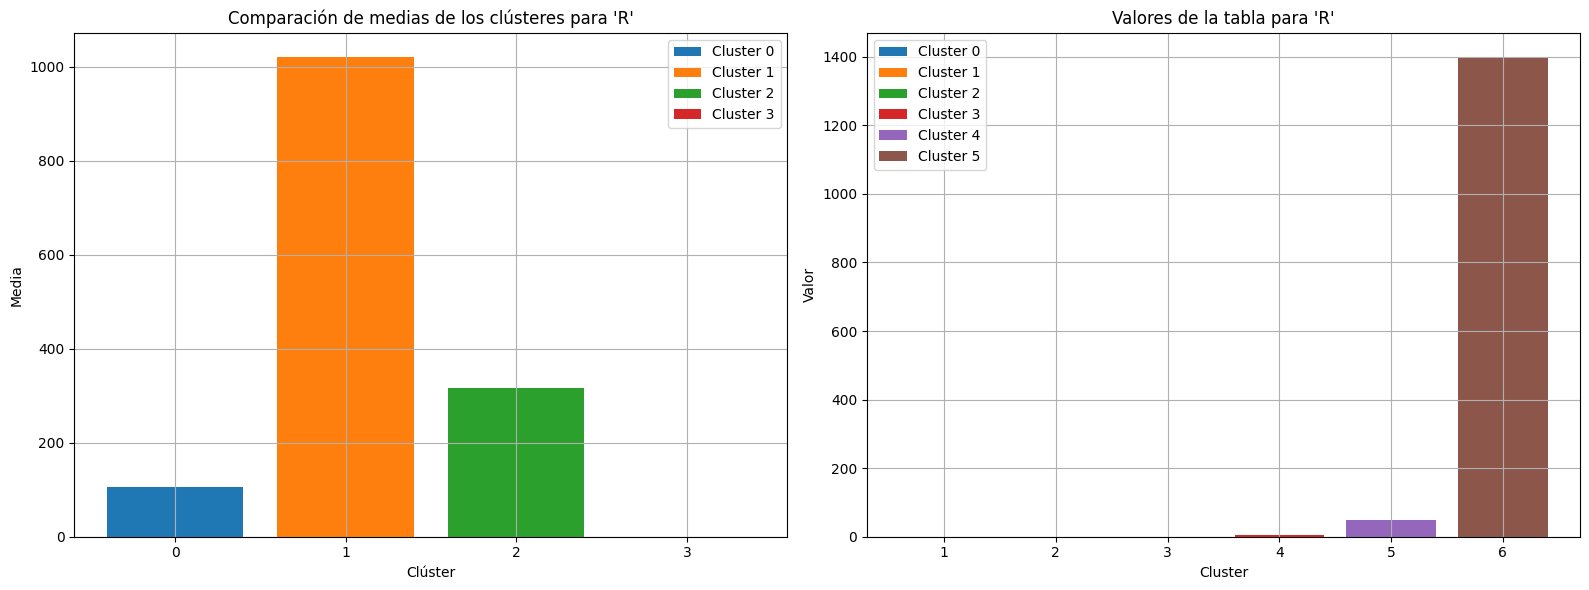

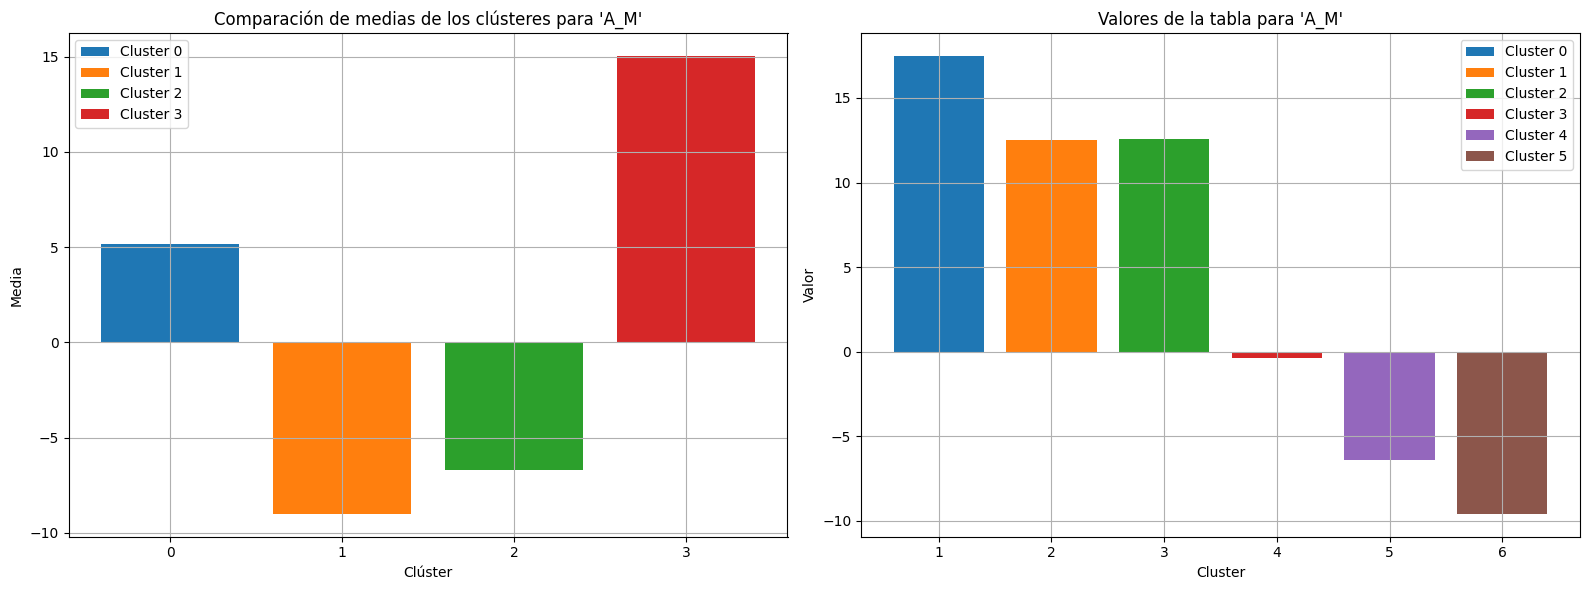

In [44]:
# Datos proporcionados
data = {
    "Temperature": [3000, 3300, 14000, 16000, 15000, 11000],
    "L": [0.0007, 0.0055, 0.0025, 32000.0, 300000.0, 300000.0],
    "R": [0.1, 0.35, 0.01, 4.4, 50.0, 1400.0],
    "A_M": [17.5, 12.5, 12.6, -0.4, -6.4, -9.6],
    "Color": ['rojo', 'rojo', 'blanca', 'blancaamarilla', 'blancaamarilla', 'amarilla']
}

# Colores para los gráficos
colors = plt.cm.tab10.colors

# Graficar comparación de medias de los clústeres y mostrar tablas de valores
for column, data_list in means.items():
    if column != "Cluster_Label":
        plt.figure(figsize=(16, 6))

        # Subplot 1: Comparación de medias de los clústeres
        plt.subplot(1, 2, 1)
        plt.title(f"Comparación de medias de los clústeres para '{column}'")
        plt.xlabel("Clúster")
        plt.ylabel("Media")

        # Extraer los datos de los clústeres y las medias
        cluster_labels, cluster_means = zip(*data_list)

        # Graficar las barras con colores personalizados por clúster
        for i, (label, mean) in enumerate(zip(cluster_labels, cluster_means)):
            plt.bar(label, mean, color=colors[i], label=f'Cluster {label}')

        plt.xticks(cluster_labels)
        plt.legend()
        plt.grid(True)

        # Subplot 2: Tabla de valores para la columna actual
        plt.subplot(1, 2, 2)
        plt.title(f"Valores de la tabla para '{column}'")
        plt.xlabel("Cluster")
        plt.ylabel("Valor")
        for i, j in enumerate(data[column]):
            plt.bar(i, j, color=colors[i], label=f'Cluster {i}')
        plt.xticks(np.arange(len(data[column])), np.arange(len(data[column])) + 1)
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()


# Conclusiones finales
Como se puede observar, los valores de los clusters difieren bastante con respecto a los de ejemplo, pero era de esperar ya que nuestra solución óptima se compone de 4 agrupaciones de datos, mientras que el ejemplo de 6, por lo que, por ejemplo en temperatura, es probable que nuestro cluster agrupase los clusters 3 y 4 o 3,4 y 5 en uno solo.

### Centroides
Aunque al final no hacemos uso de ello, previamente usábamos la función `inverse_transform` para deshacer las transformaciones del PCA y sacar los datos de cada cluster y sus centroides.

In [ ]:
# Para hacer un análisis de que datos están agrupados en cada centroide, lo primero es obtener los centroides
# Calcular los centroides manualmente
centroids = np.empty((len(unique_labels), data_pca.shape[1]))
for i, label in enumerate(unique_labels):
    cluster_data_pca = data_pca[cluster_labels == label]
    centroid = np.mean(cluster_data_pca, axis=0)
    centroids[i] = centroid

# Y aplicamos la inversa del PCA para ver los datos sin reduccion de dimensionalidad
centroids_original = pca.inverse_transform(centroids)


cluster_data_original = {}
for label in unique_labels:
    cluster_data_pca = data_pca[cluster_labels == label]
    cluster_data_original[label] = pca.inverse_transform(cluster_data_pca)

# Mostrar los resultados
plt.figure(figsize=(10, 6))
plt.title('Final Results')
for label in unique_labels:
    plt.scatter(data_pca[cluster_labels == label, 0], data_pca[cluster_labels == label, 1], label=f'Cluster {label}')

# Mostrar los centroides en el espacio PCA
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', color='black', label='Centroides (PCA)')

plt.legend()
plt.grid(True)
plt.show()
